In [ ]:
  %load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/cs7643
import sys
sys.path.append('/content/drive/MyDrive/cs7643')
!pip install mlflow skorch
# !pip install Ipython --upgrade
%cd /content/drive/MyDrive/cs7643

Mounted at /content/drive
'Copy of run3.ipynb'	 pipeline_template.py   run3.ipynb   run8_selfatt_unweighted.ipynb
 data			 plots		        run4.ipynb   run9_selfatt_final.ipynb
 experiment_configs.py	 __pycache__	        run5.ipynb
 mlruns			 run1.ipynb	        run6.ipynb
 models			 run2.ipynb	        run7.ipynb
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.1/575.1 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203

In [ ]:
%ls

'Copy of run3.ipynb'     pipeline_template.py   run3.ipynb   run8_selfatt_unweighted.ipynb
 data/                   plots/                 run4.ipynb   run9_selfatt_final.ipynb
 experiment_configs.py   __pycache__/           run5.ipynb
 mlruns/                 run1.ipynb             run6.ipynb
 models/                 run2.ipynb             run7.ipynb


In [ ]:
import pipeline_template, mlflow, torch, torchvision
from experiment_configs import configs, ExperimentConfig, ModelConfig, DataConfig
from models.resnet_self_att import ResnetSelfAtt
from models.originalBasicBlock import OriginalBasicBlock
from skorch.callbacks import LRScheduler
from skorch.dataset import ValidSplit
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.transforms import transforms
mlflow.set_tracking_uri('file:/content/drive/MyDrive/cs7643/mlruns')

In [19]:
myconfig={"self_att_final": lambda: ExperimentConfig(
        "SelfAtt ResNet20 Final",
        DataConfig(name='CIFAR-10',
                   test_size=10000,
                   train_transform=transforms.Compose([
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomCrop(32, padding=4),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.4918687901200927, 0.49185976472299225, 0.4918583862227116], std=[0.24697121702736, 0.24696766978537033, 0.2469719877121087])
            ]),
            test_transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.4918687901200927, 0.49185976472299225, 0.4918583862227116], std=[0.24697121702736, 0.24696766978537033, 0.2469719877121087])
            ])),
        ModelConfig(model=ResnetSelfAtt(OriginalBasicBlock, [3,3,3], 10),
                    lr=0.0005,
                    optimizer=torch.optim.Adam,
                    weight_decay=0.001,
                    use_reg=True,
                    batch_size=128,
                    max_epochs=64000//(45000 // 128),
                    momentum=0.9,
                    train_split=None,
                    scheduler=LRScheduler(
                        policy=MultiStepLR,
                        milestones=[
                            32000 // (45000 // 128), # == 91
                            115,
                            # 48000 // (45000 // 128) # == 136 #original
                        ],
                        gamma=0.1 # this is the multiplication factor ("divide it by 10")
                    ),
                    log_model=True,
                    early_stopping_params={
                        'patience': 20,
                        'threshold': 0.001,
                        'threshold_mode': 'rel'
                    },
                    use_early_stopping=True,
                    add_test_set_eval=True,
                    )
    )}

NoneType: None


=== Model Details ===
ResnetSelfAtt(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): OriginalBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
    )
    (1): OriginalBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1

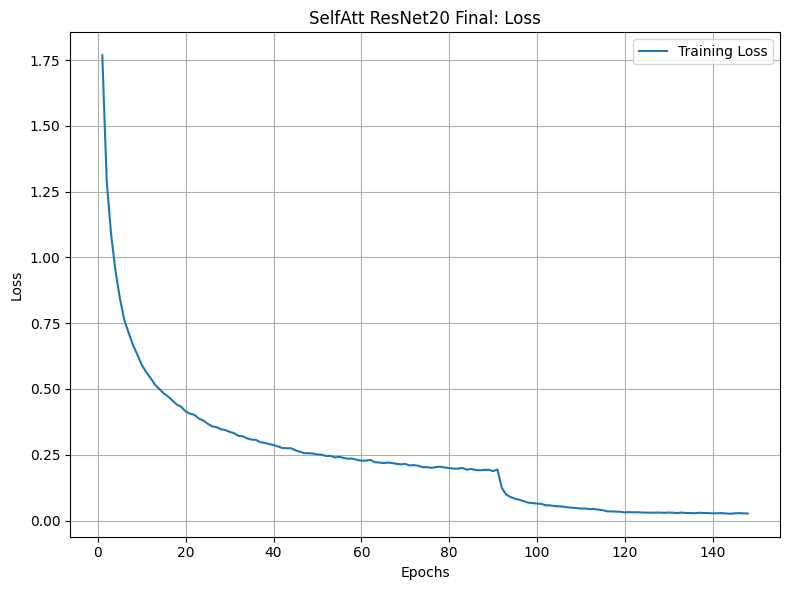

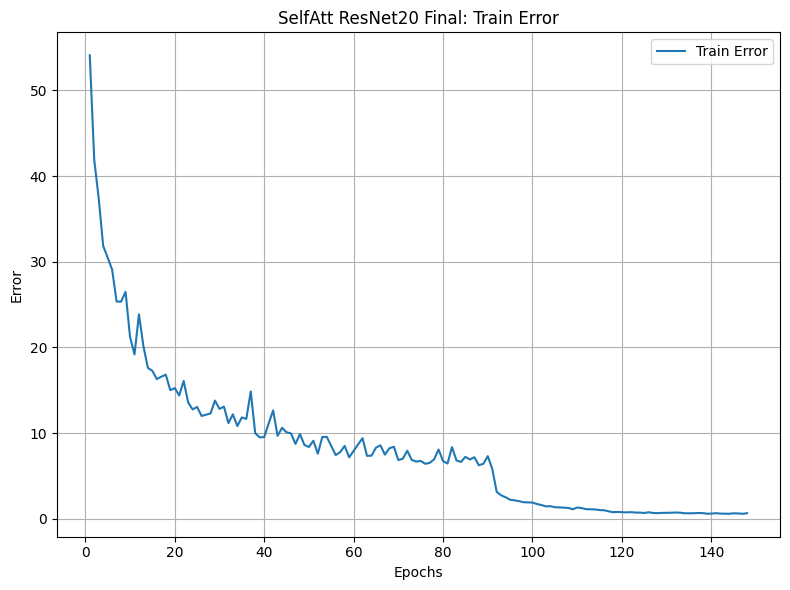

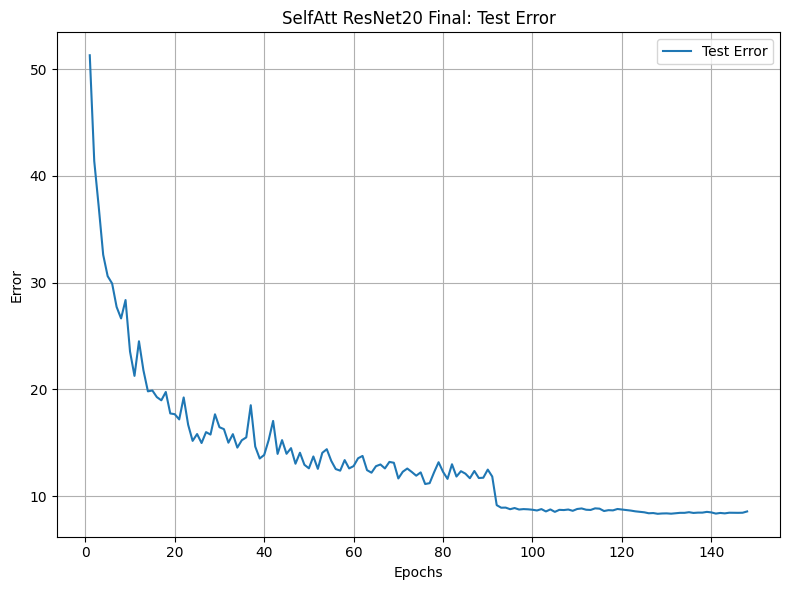

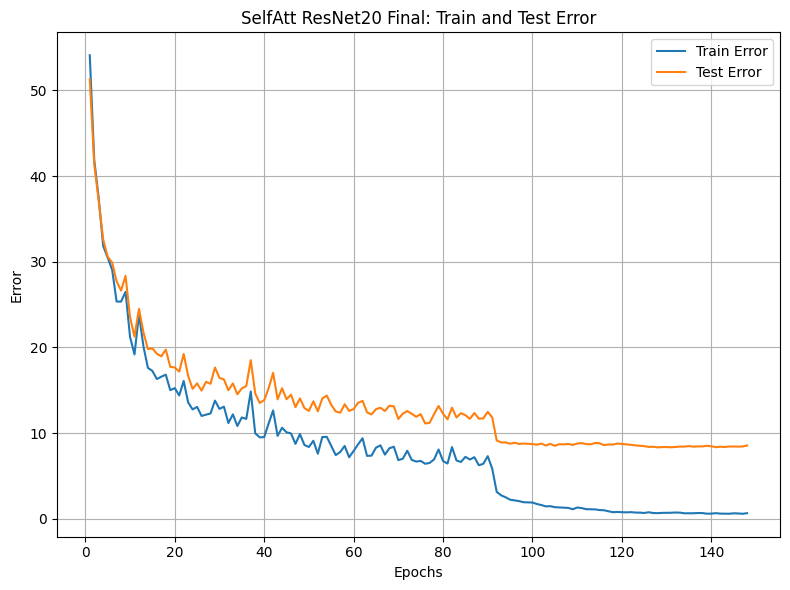

2024/12/08 17:07:33 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/08 17:07:37 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/08 17:07:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [20]:
pipeline_template.main('self_att_final', True, myconfig)
# pipeline_template.main('debug_config')